In [2]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

iris_df = pd.DataFrame(data=iris.data, columns=feature_names)
iris_df['target'] = iris.target

### GMM Clustering과 K-Means 알고리즘의 성능 비교
    * GMM으로 군집화한 붓꽃 데이터는 Target값이 0일 때 0만, 2일때 2만 군집이 되어있는 것을 확인할 수 있음
    * 이에 반해 평균 거리 중심으로 중심 이동하는 K-Means의 경우 일부 군집결과가 잘 안되는 것을 확인할 수 있음
    * GMM이 K-Means보다 붓꽃데이터 군집화에 더 적합한 것을 확인할 수 있음
    * 단, 이는 개별 군집 내의 데이터가 원형으로 흩어져 있지 않은 붓꽃 데이터의 특성 때문임
        (K-Means는 데이터의 군집 모형이 원형일 경우 성능이 좋음)

In [8]:
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

iris_df['gmm_cluster'] = gmm_cluster_labels
iris_df['target'] = iris.target

iris_result = iris_df.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       1              45
        2               5
2       2              50
Name: gmm_cluster, dtype: int64


In [10]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
iris_df['kmeans_cluster'] = kmeans_cluster_labels
iris_result = iris_df.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       2                 48
        0                  2
2       0                 36
        2                 14
Name: kmeans_cluster, dtype: int64


### 원형 데이터 세트에서의 GMM과 K-Means의 성능 비교
    * Kmeans는 원형의 범위에서 군집화의 효율이 높아짐
    * make_blobs()의 군집 수를 3개로 하되, cluster_std를 0.5로 하여 군집내의 데이터를 뭉치게 만들어K-Means를 적용
    * cluster_std를 작게 설정하면 데이터들의 형태가 원형으로 분산됨
    * 만약, 데이터가 원형이 아닌, 타원형일 경우에는 KMeans의 성능이 떨어지는 것을 볼 수 있음
    * visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True)함수를 통해서 시각화를 할 예정
        * clusterobj : sklearn의 KMeans 또난 GMM의 fit()와 predict()로 군집화한 객체, makeblob()으로 생성한 데이터의 경우 None
        * dataframe : 피처 데이터 세트와 label 값을 가진 Dataframe
        * lable_name : 군집화 결과 시각화일 경우 dataframe 내의 군집화 label 칼럼명, make_blobs()결과 시각화일 경우 dataframe내의
                        target 칼럼명
        * iscenter : sklearn Cluster객체가 군집 중심 좌표를 제공하면 True, 아니면 False

In [25]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    temp_df = dataframe
    target_list = np.unique(temp_df[label_name])
    
    if iscenter==True:
        centers = clusterobj.cluster_centers_
    
    markers=['o', 's', '^', 'P', 'D', 'H', 'x']
    
    for target in target_list:
        target_cluster = temp_df[temp_df[label_name]==target]
        plt.scatter(x=target_cluster['ftr1'], y=target_cluster['ftr2'], edgecolor='K', marker=markers[target])
        
        if iscenter==True:
            center_x_y = centers[target]         
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white', alpha=0.9, edgecolor='k', marker=markers[target])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % target)
    
    plt.show()

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
cluster_df = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
cluster_df['target'] = y
visualize_cluster_plot(None, cluster_df, 'target', iscenter=False)

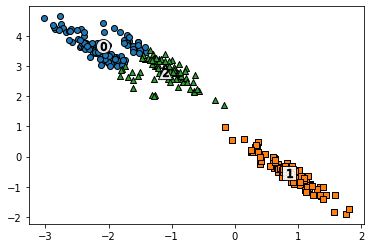

In [28]:
kmeans=KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
cluster_df['kmeans_label']=kmeans_label

visualize_cluster_plot(kmeans, cluster_df, 'kmeans_label', iscenter=True)

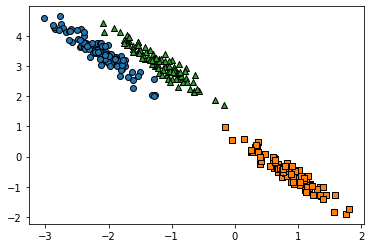

In [30]:
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
cluster_df['gmm_label'] = gmm_label

visualize_cluster_plot(gmm, cluster_df, 'gmm_label', iscenter=False)

* Kmeans의 경우 타원형태의 데이터에 대한 군집화 성능이 떨어지는 것을 알 수 있음
* GMM의 경우 타원형태의 데이터도 군집화 성능이 높음
* 다만, GMM은 Center에 대한 좌표를 제공하지 않으므로, make_blobs()의 Target값과 KMean, GMM의 군집 label을 비교하여 성능 검증해야함

In [31]:
print('### KMeans Clustering ###')
print(cluster_df.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(cluster_df.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64
